In [1]:
import numpy as np
import matplotlib.pyplot as plt
import load as load
import plotting as pl


import time
import ant as ANT
import ant_grid as GRID


import imp


In [2]:
imp.reload(ANT)
imp.reload(pl)
imp.reload(GRID)
imp.reload(load)

<module 'load' from '/home/janik/Praktikum_medPhys/FirstSearchAlgos/code/load.py'>

In [3]:
pathToOARs = '/home/janik/Praktikum_medPhys/FirstSearchAlgos/Test-2/plans/plan-1/gt-maps/track-1-map.txt'
pathToColl = '/home/janik/Praktikum_medPhys/FirstSearchAlgos/Test-2/setups/setup-1/collision-map.txt'
pathToCTrestr = '/home/janik/Praktikum_medPhys/FirstSearchAlgos/Test-2/setups/setup-1/ctRestriction-map.txt'

collMap = load.load3DColorwash(pathToColl,setOneToInfty=True)[3]
cTrestrMap = load.load3DColorwash(pathToCTrestr,setOneToInfty=True)[3]

dim, ga, ta, oARmap = load.load3DColorwash(pathToOARs)

In [4]:
forbidden = np.maximum(cTrestrMap,collMap) 
gt_map = np.maximum(oARmap,forbidden) 

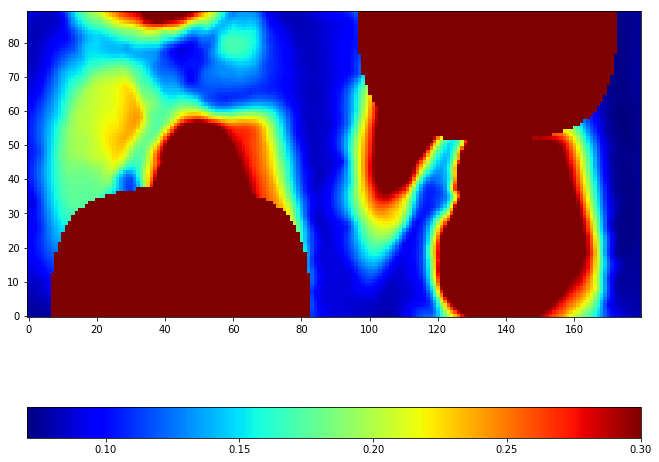

In [5]:
pl.FlooadPlot(pic=gt_map,flood_level=0.3)
plt.show()

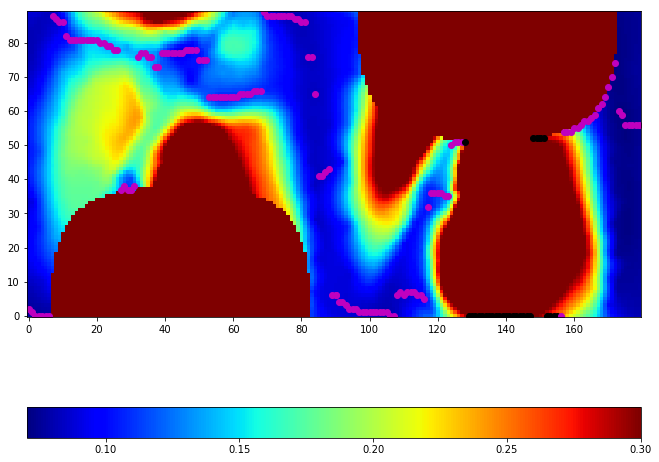

In [6]:
plt.figure(figsize=(11,11))

pl.FlooadPlot(pic=gt_map,flood_level=0.3)

for s in np.linspace(0,30,31) :
    pl.LinePlot(pic=gt_map,start=int(s))

plt.show()

In [7]:
nest_food_combinations = []
for g_angle in np.arange(0,121,30) :
    t_angle = np.argmin(gt_map[:,g_angle])
    nest_food_combinations.append((g_angle,t_angle))

In [8]:
nest_food_combinations = [(0,88),(40,80),(65,60),(85,40),(120,48)]

In [9]:
from multiprocessing import Pool
pool = Pool()

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/janik/anaconda2/envs/py3k/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/janik/anaconda2/envs/py3k/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/janik/anaconda2/envs/py3k/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/janik/anaconda2/envs/py3k/lib/python3.6/multiprocessing/queues.py", line 345, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'AOC_path' on <module '__main__'>
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
  File "/home/janik/anaconda2/envs/py3k/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/janik/anaconda2/envs/py3k/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Tracebac

In [10]:
pheromone_0 = {}
set_pheromone_const =  10.

dist_cost = {}

for x in range(180) :
    for y in range(90) :
        for n in ANT.GetNeighbours((x,y)) :
            pheromone_0[(x,y),n] = set_pheromone_const
            dist_cost[(x,y),n] = 1. / gt_map[n[::-1]]


DecTable1 = GRID.AntDecisionTable(pheromone=pheromone_0, distance=dist_cost,alpha=1.,beta=4.)
DecTable2 = GRID.AntDecisionTable(pheromone=pheromone_0, distance=dist_cost,alpha=1.,beta=4.)
DecTable3 = GRID.AntDecisionTable(pheromone=pheromone_0, distance=dist_cost,alpha=1.,beta=4.)
DecTable4 = GRID.AntDecisionTable(pheromone=pheromone_0, distance=dist_cost,alpha=1.,beta=4.)


In [33]:
def GetMaxProbaPath (start, goal, decisionTable) :
    path = []
    path.append(start) 
    
    current = start
    while current[0] != goal[0] :
        max_proba = 0.
        for n in ANT.GetNeighbours(point=current) :
            if n not in path :
                proba = decisionTable.p_ij(location=current,destination=n,track=path)
                #print(proba)
                if proba > max_proba :
                    max_proba = proba
                    next_point = n
        #print (next_point)
        path.append(next_point)
        current = next_point
    
    return path

In [34]:
def AOC_path (nest, food, DecTable, no_of_colonies = 30) :
    """
    This function return the best (maximum proability) ant path connecting the nest with food.
    """
    go = time.time()
    no_of_critical_ants = 0
    cost_goal_generation = 0.3
    for generation in range(no_of_colonies) :
    
        if no_of_critical_ants < 30 :
            cost_goal_generation -= 0.001 
        else : cost_goal_generation += 0.001

        #print 'reduced goal', cost_goal_generation
        #print 'no_of_critical_ants', no_of_critical_ants

        ant_colony = []
        no_of_critical_ants = 0

        for m in range(30) :
            ant = ANT.Ant(birth_coordinates=nest)
            ant_colony.append(ant) 

            while (ant.location != food) :

                loc = ant.location
                state_transition_probas = []

                neigbours = ANT.GetNeighbours(point=loc)


                for n in neigbours :
                    state_transition_probas.append(DecTable.p_ij(location=loc,destination=n,track=ant.track))

                next_state = GRID.GetNextState(state_transition_probas=state_transition_probas,neigbours=neigbours)
                ant.AddMove(nextpoint=next_state)

                colormap_value = 1./ DecTable.eta_ij[loc,next_state]
                ant.AddCost(value=colormap_value)

                #print colormap_value
                if colormap_value >= cost_goal_generation :
                    ant.critical_steps += 1

                if ant.critical_steps > 1 :
                    #print 'dead'
                    no_of_critical_ants += 1
                    break



                # if level reached of the food one, go up or down
                if (ant.location[0] == food[0]) :

                    while loc[1] != food[1] :
                        loc = ant.location

                        #walk up
                        if loc[1] < food[1] :
                            next_state = (loc[0],loc[1]+1)
                        else :
                            next_state = (loc[0],loc[1]-1)

                        ant.AddMove(nextpoint=next_state)
                        #print 1./DecTable.eta_ij[loc,next_state]
                        colormap_value = 1./ DecTable.eta_ij[loc,next_state]
                        ant.AddCost(value=colormap_value)

                        #print colormap_value

                        if colormap_value >= cost_goal_generation :
                            ant.critical_steps += 1

                        if ant.critical_steps > 1 :
                            #print 'dead'
                            no_of_critical_ants += 1
                            break

                    break



        DecTable.UpdatePheromone(colony=ant_colony)

        """
        for n in ANT.GetNeighbours((108,45)) :
            print n
            print DecTable.p_ij(location=(108,45), destination=n)
        """

        #print ('reduced goal', cost_goal_generation)
        #print( 'no_of_critical_ants', no_of_critical_ants)

        """
        if generation%100 == 0 :
            print (generation)

            plt.figure(figsize=(11,11))
            pl.FlooadPlot(pic=gt_map,flood_level=0.3)

            cost_in_generation = []
            for a in ant_colony :
                track_length = 1.*len(a.track)
                pl.PlotTrack(track=a.track)
                #plt.pause(0.05)
                if a.critical_steps < 2 :
                    #print 'hi'
                    cost_in_generation.append(a.cost / track_length)
                else :   
                    cost_in_generation.append(1.)
                #print TrackCost(ant=a,cost_map=astar_landscape)
            print ('minimal track', np.argmin(cost_in_generation))
            print ('cost', ant_colony[np.argmin(cost_in_generation)].cost)
            print ('cost per unit length', ant_colony[np.argmin(cost_in_generation)].cost / len(ant_colony[np.argmin(cost_in_generation)].track))
            print ('amount of critical steps', ant_colony[np.argmin(cost_in_generation)].critical_steps)


            pl.HighlightTrack(ant_colony[np.argmin(cost_in_generation)].track)
            plt.show()
        """
    stop = time.time()

    print ('total time: ', stop-go)
    return GetMaxProbaPath(start=nest,goal=food,decisionTable=DecTable)

In [35]:
print (nest_food_combinations)
print (nest_food_combinations[1:])
print (nest_food_combinations[:-1])


[(0, 88), (40, 80), (65, 60), (85, 40), (120, 48)]
[(40, 80), (65, 60), (85, 40), (120, 48)]
[(0, 88), (40, 80), (65, 60), (85, 40)]


In [36]:
from itertools import repeat

In [50]:
go = time.time()
full_path = []
with Pool(2) as p :
    full_path.append((p.starmap(AOC_path,zip(nest_food_combinations[:-1],nest_food_combinations[1:],repeat(DecTable1),repeat(30)))))

print('time for full path', time.time()-go)
    

total time:  5.362618446350098
total time:  3.936152935028076
total time:  2.698059558868408
total time:  2.4249937534332275
time for full path 11.2222900390625


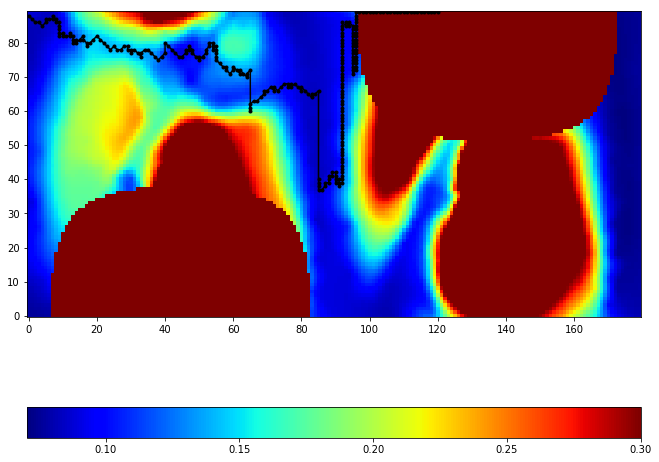

In [46]:
plt.figure(figsize=(11,11))
pl.FlooadPlot(pic=gt_map,flood_level=0.3)
pl.PlotTrack(track=np.vstack(full_path[0]))
plt.show()